<a href="https://colab.research.google.com/github/danielabebe1/Capstone2/blob/master/dcmExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
# https://www.kaggle.com/sentdex/first-pass-through-data-w-3d-convnet
!pip install pydicom
import pydicom as dicom 
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

     |████████████████████████████████| 35.5MB 120kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
data_dir = '/content/drive/My Drive/OSIC Pulmonary Fibrosis/train/'
patients = os.listdir(data_dir)
train_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train.csv'
test_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/test.csv'
sub_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/sample_submission.csv'
#read csv
train=pd.read_csv(train_csv)
test=pd.read_csv(test_csv)
sub=pd.read_csv(sub_csv)
sub[['Patient','Weeks']]=sub.Patient_Week.str.split("_",expand = True)

In [27]:
GDCM_scan=['ID00132637202222178761324','ID00128637202219474716089','ID00052637202186188008618','ID00026637202179561894768','ID00011637202177653955184']

patients=[x for x in patients if x not in GDCM_scan]
print(len(patients))

171


In [5]:
for patient in patients[:1]:
  path = data_dir + patient
  slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
  print(len(slices))
  print(slices[0])

290
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.57902026949590981269191941333112179190
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008, 0018) SOP Instance UID                    UI: 2.25.57902026949590981269191941333112179190
(0008, 0060) Modality                            CS: 'CT'


In [ ]:
for patient in patients[:3]:
  path = data_dir + patient
  slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
  print(slices[0].pixel_array.shape, len(slices))

(512, 512) 290
(512, 512) 56
(1100, 888) 28


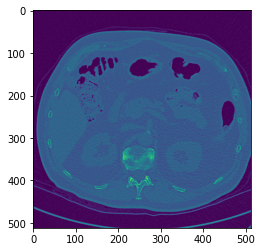

In [6]:
for patient in patients[:1]:
  path = data_dir + patient
  slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
  plt.imshow(slices[0].pixel_array)
  plt.show()

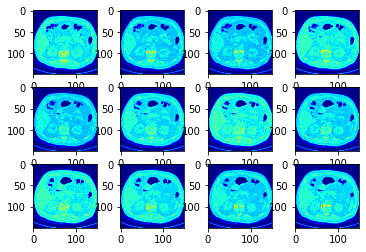

<Figure size 432x288 with 0 Axes>

In [7]:
import cv2
import numpy as np

IMG_PX_SIZE = 150

for patient in patients[:1]:
  path = data_dir + patient
  slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
  fig = plt.figure()
  for num,each_slice in enumerate(slices[:12]):
    y = fig.add_subplot(3,4,num+1)
    new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
    y.imshow(new_img,cmap='jet')
  plt.show()
  plt.tight_layout()

In [8]:
import math
def chunks(l, n):
  for i in range(0, len(l), n):
    yield l[i:i + n]
def mean(l):
    return sum(l) / len(l)
IMG_PX_SIZE = 150
HM_SLICES = 20

for patient in patients[:5]:
  try:
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
      slice_chunk = list(map(mean, zip(*slice_chunk)))
      new_slices.append(slice_chunk)
    print(len(slices), len(new_slices))
  except:
    pass

290 20
56 19
28 14
473 20
408 20


In [10]:
for patient in patients[:10]:
  try:
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)

    for slice_chunk in chunks(slices, chunk_sizes):
      slice_chunk = list(map(mean, zip(*slice_chunk)))
      new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
      new_slices.append(new_slices[-1])
      new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
      new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
      new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
      del new_slices[HM_SLICES]
      new_slices[HM_SLICES-1] = new_val

    if len(new_slices) == HM_SLICES+1:
      new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
      del new_slices[HM_SLICES]
      new_slices[HM_SLICES-1] = new_val

    print(len(slices), len(new_slices))

  except Exception as e:
    print(str(e))

290 20
56 20
28 14
473 20
408 20
250 20
62 16
278 20
30 15
54 19


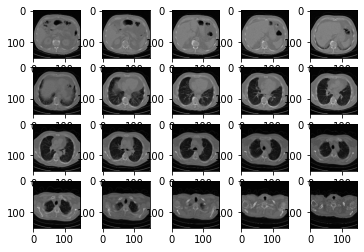

<Figure size 432x288 with 0 Axes>

In [11]:
for patient in patients[:1]:
  path = data_dir + patient
  slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
  new_slices = []

  slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
  chunk_sizes = math.ceil(len(slices) / HM_SLICES)
  for slice_chunk in chunks(slices, chunk_sizes):
    slice_chunk = list(map(mean, zip(*slice_chunk)))
    new_slices.append(slice_chunk)

  if len(new_slices) == HM_SLICES-1:
    new_slices.append(new_slices[-1])

  if len(new_slices) == HM_SLICES-2:
    new_slices.append(new_slices[-1])
    new_slices.append(new_slices[-1])
  if len(new_slices) == HM_SLICES+2:
    new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
    del new_slices[HM_SLICES]
    new_slices[HM_SLICES-1] = new_val
          
  if len(new_slices) == HM_SLICES+1:
    new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
    del new_slices[HM_SLICES]
    new_slices[HM_SLICES-1] = new_val
      
  fig = plt.figure()
  for num,each_slice in enumerate(new_slices):
    y = fig.add_subplot(4,5,num+1)
    y.imshow(each_slice, cmap='gray')
  plt.show()
  plt.tight_layout()


In [12]:
IMG_SIZE_PX = 50
SLICE_COUNT = 20

def chunks(l, n):
  for i in range(0, len(l), n):
    yield l[i:i + n]

def mean(a):
  return sum(a) / len(a)

def process_data(patients,img_px_size=50, hm_slices=20, visualize=False):
    
  path = data_dir + patients
  slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

  new_slices = []
  slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
  chunk_sizes = math.ceil(len(slices) / hm_slices)
  for slice_chunk in chunks(slices, chunk_sizes):
    slice_chunk = list(map(mean, zip(*slice_chunk)))
    new_slices.append(slice_chunk)

  if len(new_slices) == hm_slices-1:
    new_slices.append(new_slices[-1])

  if len(new_slices) == hm_slices-2:
    new_slices.append(new_slices[-1])
    new_slices.append(new_slices[-1])

  if len(new_slices) == hm_slices+2:
    new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
    del new_slices[hm_slices]
    new_slices[hm_slices-1] = new_val
        
  if len(new_slices) == hm_slices+1:
    new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
    del new_slices[hm_slices]
    new_slices[hm_slices-1] = new_val

  if visualize:
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
      y = fig.add_subplot(4,5,num+1)
      y.imshow(each_slice, cmap='gray')
    plt.show()
       
  return np.array(new_slices)

In [13]:
dcm_data = []
for num,patient in enumerate(patients[:20]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [14]:
dcm_data1 = []
for num,patient in enumerate(patients[20:40]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data1.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [15]:
dcm_data2 = []
for num,patient in enumerate(patients[40:60]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data2.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [16]:
dcm_data3 = []
for num,patient in enumerate(patients[60:80]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data3.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [17]:
dcm_data4 = []
for num,patient in enumerate(patients[80:100]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data4.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [18]:
dcm_data5 = []
for num,patient in enumerate(patients[100:120]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data5.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


AttributeError: ignored

In [20]:
dcm_data5 = []
for num,patient in enumerate(patients[116:117]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data5.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


AttributeError: ignored

In [21]:
#By trial and error we find that patient 'ID00132637202222178761324' has no attribute ImagePositionPatient. 
#Hence we get rid of it from the list
patients[116:117]

['ID00132637202222178761324']

In [28]:
#in the same way, ('ID00128637202219474716089','ID00052637202186188008618','ID00026637202179561894768','ID00011637202177653955184) patients have no 
#ImagePositionPatient attribute

GDCM_scan=['ID00132637202222178761324','ID00128637202219474716089','ID00052637202186188008618','ID00026637202179561894768','ID00011637202177653955184']

patients=[x for x in patients if x not in GDCM_scan]
print(len(patients))

171


In [ ]:

# GDCM_scan=['ID00011637202177653955184', 'ID00052637202186188008618','ID00132637202222178761324','ID00128637202219474716089',
#            'ID00026637202179561894768']

In [23]:
#After getting rid of the patient ID00132637202222178761324
dcm_data5 = []
for num,patient in enumerate(patients[100:120]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data5.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [24]:
dcm_data6 = []
for num,patient in enumerate(patients[120:140]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data6.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [ ]:
patients[120:121]

['ID00128637202219474716089']

In [26]:
dcm_data7 = []
for num,patient in enumerate(patients[120:140]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data7.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [29]:
dcm_data7 = []
for num,patient in enumerate(patients[140:160]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data7.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [30]:
dcm_data7 = []
for num,patient in enumerate(patients[140:160]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data7.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [31]:
dcm_data8 = []
for num,patient in enumerate(patients[160:]):
  if num % 100 == 0:
    print(num)
  try:
    img_data = process_data(patient, img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
    dcm_data8.append([img_data])
  except KeyError as e:
    print('This is unlabeled data!')

0


In [34]:
dcms_data=dcm_data+dcm_data1+dcm_data2+dcm_data3+dcm_data4+dcm_data5+dcm_data6+dcm_data7+dcm_data8

In [39]:
# Convert to a pd.DataFrame from dict
dcm_data_df = pd.DataFrame.from_dict(dcms_data)
dcm_data_df.head()

,0
0,"[[[34.266666666666666, 42.733333333333334, 36...."
1,"[[[0.0, 0.0, 0.0, 48.666666666666664, 48.33333..."
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,"[[[730.6666666666666, 730.6666666666666, 730.6..."
4,"[[[0.0, 0.0, 0.0, 27.0, 30.333333333333332, 29..."


In [37]:
#let's pickle for later use
dcm_data_df.to_pickle("meta_dcmdata_df.pkl")

In [40]:
len(dcm_data_df)

151

In [41]:
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
        # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
     # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
      # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0
    
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    
    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img


In [ ]:
for patient in patients:
  path = data_dir + patient
  slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
  imgs=slices.pixel_array
  